In [1]:
%matplotlib widget

Dynamically determined burn-in period: 3


/tmp/ipykernel_57084/3689137193.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1000x1500', '-pix_fmt', 'rgba', '-framerate', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'metropolis_hastings_trace_animation.mp4']' returned non-zero exit status 255.

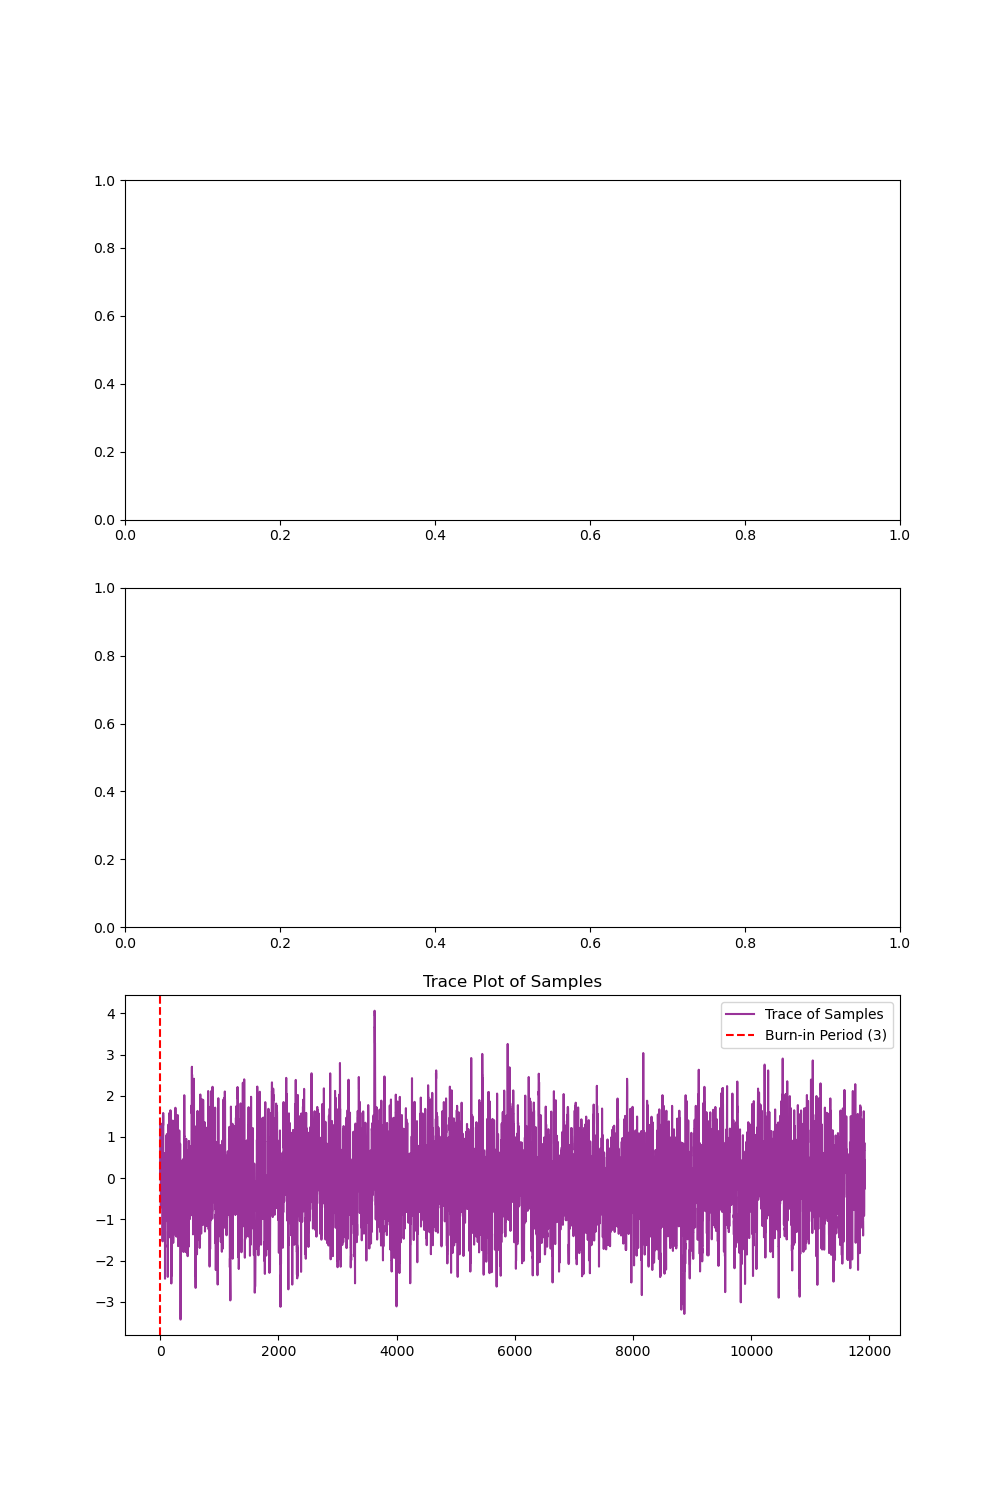

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Target distribution (Gaussian)
def target_distribution(x):
    """
    Target distribution proportional to a Gaussian distribution.
    """
    return np.exp(-0.5 * x**2)

def metropolis_hastings(target, initial_sample, proposal_std=1.0, max_samples=20000, window_size=100):
    """
    Metropolis-Hastings algorithm with dynamic burn-in detection based on running mean and variance.
    """
    samples = []
    current_sample = initial_sample
    running_mean = []
    running_var = []
    
    burn_in_period = 0  # Dynamically determine the burn-in period
    
    for i in range(max_samples):
        # Propose a new sample
        proposed_sample = np.random.normal(current_sample, proposal_std)
        acceptance_ratio = min(1, target(proposed_sample) / target(current_sample))
        
        if np.random.rand() < acceptance_ratio:
            current_sample = proposed_sample
        
        samples.append(current_sample)
        
        # Check for burn-in stabilization if enough samples are available
        if i >= window_size:
            window = samples[-window_size:]
            current_mean = np.mean(window)
            current_var = np.var(window)
            running_mean.append(current_mean)
            running_var.append(current_var)
            
            # Burn-in determination based on stabilization
            if len(running_mean) > 2:
                mean_change = abs(running_mean[-1] - running_mean[-2])
                var_change = abs(running_var[-1] - running_var[-2])
                if mean_change < 0.001 and var_change < 0.001 and burn_in_period == 0:
                    burn_in_period = i + 1 - window_size
    
    return np.array(samples), burn_in_period

# Parameters
initial_sample = 0.0
proposal_std = 1.0
max_samples = 20000
window_size = 100

# Run Metropolis-Hastings
samples, burn_in_period = metropolis_hastings(
    target=target_distribution,
    initial_sample=initial_sample,
    proposal_std=proposal_std,
    max_samples=max_samples,
    window_size=window_size
)

# Print burn-in period
print(f"Dynamically determined burn-in period: {burn_in_period}")

# Visualization
fig, ax = plt.subplots(3, 1, figsize=(10, 15))  # Create 3 plots

x = np.linspace(-4, 4, 1000)
y = target_distribution(x) / target_distribution(x).max()

def update(frame):
    """
    Update the histogram, target distribution, and trace plot for each frame.
    """
    ax[0].cla()  # Clear the histogram plot
    ax[1].cla()  # Clear the histogram with burn-in plot
    ax[2].cla()  # Clear the trace plot

    # Samples without burn-in
    current_samples_without_burn_in = samples[:frame]
    ax[0].hist(current_samples_without_burn_in, bins=50, density=True, alpha=0.6, color='blue', label=f"No Burn-in (N={frame})")
    ax[0].plot(x, y, label="Target Distribution", color='red', lw=2)
    ax[0].set_xlim(-4, 4)
    ax[0].set_ylim(0, 1)
    ax[0].set_title("Without Burn-in Period")
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("Density")
    ax[0].legend()
    ax[0].grid()

    # Samples with burn-in removed
    if frame > burn_in_period:
        current_samples_with_burn_in = samples[burn_in_period:frame]
        ax[1].hist(current_samples_with_burn_in, bins=50, density=True, alpha=0.6, color='green', label=f"With Burn-in (N={frame - burn_in_period})")
        ax[1].plot(x, y, label="Target Distribution", color='red', lw=2)
    ax[1].set_xlim(-4, 4)
    ax[1].set_ylim(0, 1)
    ax[1].set_title(f"With Dynamic Burn-in (Burn-in={burn_in_period})")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("Density")
    ax[1].legend()
    ax[1].grid()

    # Trace plot
    ax[2].plot(range(frame), samples[:frame], color='purple', alpha=0.8, label="Trace of Samples")
    ax[2].axvline(burn_in_period, color='red', linestyle='--', label=f"Burn-in Period ({burn_in_period})")
    ax[2].set_title("Trace Plot of Samples")
    ax[2].set_xlabel("Iteration")
    ax[2].set_ylabel("Sample Value")
    ax[2].legend()
    ax[2].grid()

    return [ax[0], ax[1], ax[2]]

# Create and persist animation
ani = FuncAnimation(fig, update, frames=np.arange(1, len(samples) + 1), interval=50, repeat=False)

# Save the animation
ani.save('metropolis_hastings_trace_animation.mp4', writer='ffmpeg', fps=30)

plt.tight_layout()
plt.show()


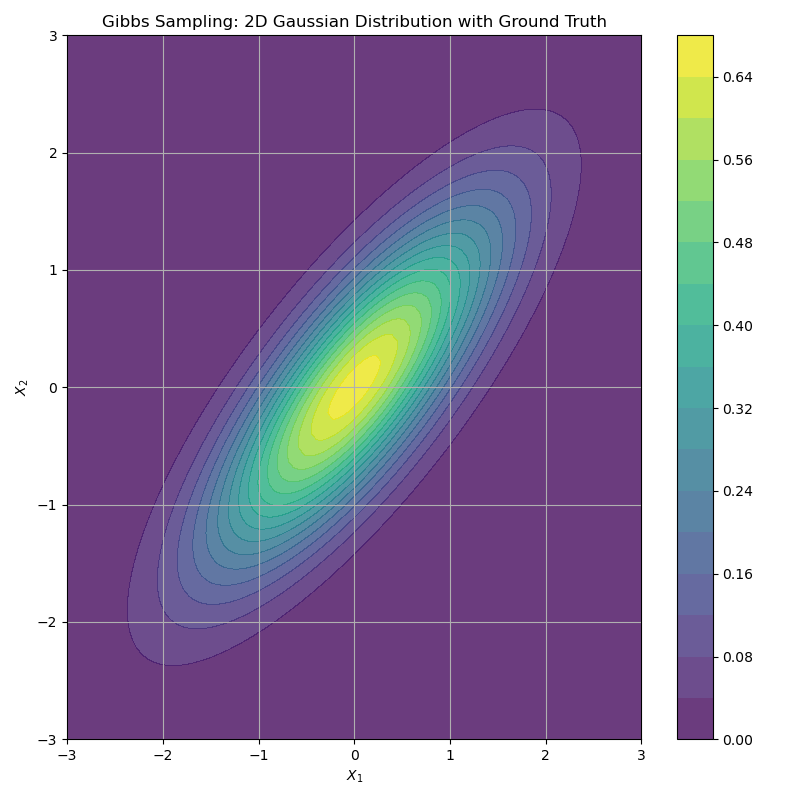

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the conditional distributions for Gibbs sampling
mu = [0, 0]  # Mean of the distribution
cov = [[1, 0.8], [0.8, 1]]  # Covariance matrix

# Conditional distribution for X1 given X2
def conditional_X1_given_X2(x2, mu, cov):
    mean = mu[0] + cov[0][1] / cov[1][1] * (x2 - mu[1])
    var = cov[0][0] - cov[0][1]**2 / cov[1][1]
    return np.random.normal(mean, np.sqrt(var))

# Conditional distribution for X2 given X1
def conditional_X2_given_X1(x1, mu, cov):
    mean = mu[1] + cov[1][0] / cov[0][0] * (x1 - mu[0])
    var = cov[1][1] - cov[1][0]**2 / cov[0][0]
    return np.random.normal(mean, np.sqrt(var))

# Gibbs sampling function
def gibbs_sampling(num_samples, mu, cov, initial_state):
    samples = np.zeros((num_samples, 2))
    samples[0] = initial_state
    
    for i in range(1, num_samples):
        # Sample X1 given X2
        x1, x2 = samples[i-1]
        if (np.random.randn() < 0.5):
            x1 = conditional_X1_given_X2(samples[i-1, 1], mu, cov)
        else:
        # Sample X2 given X1
            x2 = conditional_X2_given_X1(x1, mu, cov)
        
        # Store the sample
        samples[i] = [x1, x2]
    
    return samples

# Parameters for sampling
num_samples = 500  # Total number of samples
initial_state = [0, 0]  # Starting point for sampling

# Generate samples using Gibbs sampling
samples = gibbs_sampling(num_samples, mu, cov, initial_state)

# Define the ground truth distribution (bivariate Gaussian)
def target_distribution(x, mu, cov):
    inv_cov = np.linalg.inv(cov)
    diff = np.array(x) - np.array(mu)  # Convert x and mu to np.array for correct broadcasting
    exponent = -0.5 * np.dot(np.dot(diff, inv_cov), diff.T)
    return np.exp(exponent) / (2 * np.pi * np.linalg.det(cov))**0.5

# Create a mesh grid for contour plot
x_grid = np.linspace(-3, 3, 100)
y_grid = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_grid, y_grid)
Z = np.zeros_like(X)

# Calculate the target distribution values over the grid
for i in range(len(x_grid)):
    for j in range(len(y_grid)):
        Z[i, j] = target_distribution([X[i, j], Y[i, j]], mu, cov)

# Visualization with animated update
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_title("Gibbs Sampling: 2D Gaussian Distribution with Ground Truth")
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$")
ax.grid(True)

# Plot the target distribution (ground truth) as filled contour plot
contour = ax.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.8)  # Use filled contours with 'viridis' colormap
fig.colorbar(contour, ax=ax)  # Add a color bar for better visualization

# Initialize empty scatter plot for samples
scat = ax.scatter([], [], color='blue', alpha=0.5, label="Gibbs Samples")

# Function to update the plot for each new sample
def update(frame):
    # Update the scatter plot with the first 'frame' samples
    scat.set_offsets(samples[:frame])
    return scat,

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(1, num_samples+1), interval=50, repeat=False)

# Show the animation
plt.tight_layout()
plt.show()

# Save the animation to an MP4 file
ani.save('gibbs_sampling_with_ground_truth_enhanced.mp4', writer='ffmpeg', fps=1)


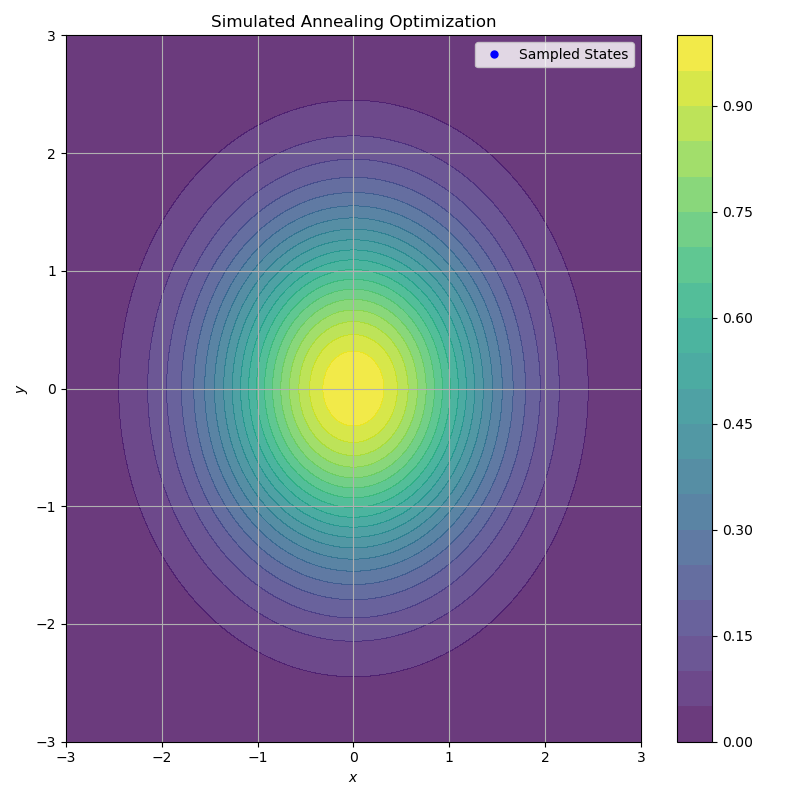

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Target function (e.g., 2D Gaussian function to minimize)
def target_function(x, y):
    return np.exp(-0.5 * (x**2 + y**2))

# Function to calculate the energy of a state
def energy(x, y):
    return target_function(x, y)

# Simulated Annealing Algorithm
def simulated_annealing(target_func, initial_state, max_iter, initial_temp, cooling_rate):
    # Initial state and parameters
    state = np.array(initial_state)
    current_energy = energy(state[0], state[1])
    
    # History for plotting
    history = [state.copy()]
    
    temp = initial_temp
    
    for _ in range(max_iter):
        # Generate new candidate state by perturbing the current state
        new_state = state + np.random.normal(0, temp, size=2)  # Perturbation
        new_energy = energy(new_state[0], new_state[1])
        
        # Decide whether to accept the new state
        if new_energy < current_energy:  # Always accept if better
            state = new_state
            current_energy = new_energy
        else:  # Accept with a probability based on temperature
            acceptance_prob = np.exp((current_energy - new_energy) / temp)
            if np.random.rand() < acceptance_prob:
                state = new_state
                current_energy = new_energy
        
        # Store the current state for visualization
        history.append(state.copy())
        
        # Cool down the temperature
        temp *= cooling_rate
        
    return np.array(history)

# Visualization of the Simulated Annealing process
def visualize_simulated_annealing(history, target_func):
    # Create grid for target function visualization (2D Gaussian)
    x_grid = np.linspace(-3, 3, 100)
    y_grid = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x_grid, y_grid)
    Z = np.zeros_like(X)
    
    # Compute the function values on the grid
    for i in range(len(x_grid)):
        for j in range(len(y_grid)):
            Z[i, j] = target_func(X[i, j], Y[i, j])

    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title("Simulated Annealing Optimization")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.grid(True)
    
    # Plot the target function as a contour plot
    contour = ax.contourf(X, Y, Z, 20, cmap='viridis', alpha=0.8)
    fig.colorbar(contour, ax=ax)

    # Initialize empty scatter plot for the path
    path, = ax.plot([], [], 'bo', markersize=5, label="Sampled States")
    ax.legend()

    # Update function for the animation
    def update(frame):
        path.set_data(history[:frame, 0], history[:frame, 1])
        return path,

    # Create the animation
    ani = FuncAnimation(fig, update, frames=np.arange(1, len(history)+1), interval=50, repeat=False)

    # Show the animation
    plt.tight_layout()
    plt.show()

    # Save the animation
    ani.save('simulated_annealing_demo.mp4', writer='ffmpeg', fps=30)

# Parameters for the Simulated Annealing
initial_state = [2.5, 2.5]  # Starting point
max_iter = 1000              # Number of iterations
initial_temp = 5.0           # Starting temperature
cooling_rate = 0.995         # Cooling rate

# Run the Simulated Annealing algorithm
history = simulated_annealing(target_function, initial_state, max_iter, initial_temp, cooling_rate)

# Visualize the process
visualize_simulated_annealing(history, target_function)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the target distribution (Gaussian in this case)
def target_distribution(x):
    """
    Target distribution proportional to a Gaussian.
    """
    return np.exp(-0.5 * x**2)

# Metropolis-Hastings algorithm
def metropolis_hastings(target, initial_sample, proposal_std=1.0, num_samples=5000):
    """
    Metropolis-Hastings algorithm for sampling from a target distribution.
    """
    samples = []
    current_sample = initial_sample
    
    for _ in range(num_samples):
        # Propose a new sample
        proposed_sample = np.random.normal(current_sample, proposal_std)
        
        # Compute acceptance ratio
        acceptance_ratio = min(1, target(proposed_sample) / target(current_sample))
        
        # Accept or reject the proposed sample
        if np.random.rand() < acceptance_ratio:
            current_sample = proposed_sample
        
        samples.append(current_sample)
    
    return np.array(samples)

# Parameters
initial_sample = 0.0
proposal_std = 1.0
num_samples = 5000

# Run Metropolis-Hastings
samples = metropolis_hastings(
    target=target_distribution,
    initial_sample=initial_sample,
    proposal_std=proposal_std,
    num_samples=num_samples
)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Histogram of the samples
x = np.linspace(-4, 4, 1000)
y = target_distribution(x) / target_distribution(x).max()  # Normalize for comparison
ax[0].hist(samples, bins=50, density=True, alpha=0.6, color='blue', label="Sampled Distribution")
ax[0].plot(x, y, color='red', lw=2, label="Target Distribution")
ax[0].set_title("Sampled Distribution vs Target Distribution")
ax[0].set_xlabel("x")
ax[0].set_ylabel("Density")
ax[0].legend()
ax[0].grid()

# Trace plot of the samples
ax[1].plot(samples, color='purple', lw=0.5, label="Trace of Samples")
ax[1].set_title("Trace Plot of Samples")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Sample Value")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()
